<h1 style ="color:teal" > House Prediction project(Bengaluru): Regression model </h2>

Dataset downloaded from https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

<h2 style ="color:red">Import libraries</h2>

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


<h2 style ="color:red">Load dataset</h2>

In [20]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [21]:
df1.shape

(13320, 9)

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [23]:
df1.area_type.value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

### Drop unwanted columns for now

In [24]:
df2 = df1.drop(['area_type','availability','society',],axis=1)

In [25]:
df2.shape

(13320, 6)

<h2 style ="color:red">Data cleaning</h2>

In [26]:
df2.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

### We see it is better to drop balcony coloumn rather than dropping the observations

In [27]:
df2.drop('balcony',inplace=True,axis = 1)
df2.shape

(13320, 5)

In [28]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [29]:
df3.shape

(13246, 5)

<h2 style = "color:red">Feature Engineering</h2>

### 'size' contains different values. So we need separate number,add a new feature called bhk

In [33]:
df3.head(5)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [36]:
df3['bhk'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))

/var/folders/_t/0f8324px4d9f4k22gxnk73lm0000gn/T/ipykernel_4330/835093312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))


In [39]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


### check whether total_sqft feature is float or not. If not make into float

In [46]:
def isfloat(x):
    try:
        float(x)
    except:
        return False
    return True

In [58]:
# ~ which return false conditon datas
df3[~df3.total_sqft.apply(isfloat)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**We see that the column contains range of values, values with different format and different units, So we take average for the range values and Ignore other columns**

In [69]:
# convert range value to number function
def convert_sqft_to_num(x):
    token = x.split('-')
    if len(token) ==2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None

In [70]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4.isnull().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

Drop null columns

In [78]:
df4 = df4[df4.total_sqft.notnull()]
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


In [79]:
# see the 30th column
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

<h2 style = "color:red">Feature Engineering</h2>

### Add a feature called price per square feet

In [80]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## Next, we have a coloumn location. Which is categrical. Look at these

- we have 1298 location. Which is very high dimensional. One hot encoding on the feature makes no sense. Because it will make curse of dimensionality. That means 1298 new features will be encoded. S

**So we need to decrease this dimension, i.e, reduce number of location**

1. See what are important locations. i.e, location which repeates more are important
2. Sort based on location and select a threshol 
3. Other locations will be considered as 'other'

In [84]:
len(df5['location'].unique())

1298

In [86]:
# Remove white spaces use strip for that
df5['location'] = df5['location'].apply(lambda x : x.strip())

# count the dataset based on location
location_stats = df5['location'].value_counts()
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [88]:
location_stats.values.sum()

13200

### count how many locations are there which has more than 10 observations(houses)

In [92]:
len(location_stats<=10)

1287

<h2 style = "color:red">Dimensionality reductions</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [94]:
location_stats_lessthan_10 = location_stats[location_stats<=10]
location_stats_lessthan_10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [95]:
# Transformation. 
#If one location is present in the list 'location_stats_lessthan_10' then this will be tretaed as other

df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_lessthan_10 else x)
len(df5.location.unique())

241

In [97]:
# see 9th value is other
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style = "color:red">Outlier removal using business logic</h2>

**As a data scientist I had  a conversation with my business manager (who has expertise in real estate), he will tells me that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If I have for example 200 sqft apartment with 2 bhk the that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [110]:
# divide square feet by number of bhk. 
df5[(df5.total_sqft/df5.bhk)<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [112]:
# store all property which has minimum 300 sqft per bedroom
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<h2 style = "color : red"> Outlier remval using SD and Mean</h2>

In [113]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [156]:
# function to remove outlier with sd 1

def remove_by_location_price(df):
    df_out = pd.DataFrame()
    for locaion, sub_df in df.groupby('location'):
        mean_pps = sub_df.price_per_sqft.mean()
        sd = sub_df.price_per_sqft.std()
        reduced_df = sub_df[(sub_df.price_per_sqft>(mean_pps-sd)) & (sub_df.price_per_sqft<(mean_pps+sd))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
    
df7 = remove_by_location_price(df6)
df7.shape

(10293, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

2bhk with same price shows higher price than 3 bhk. This may be becaus of some other factor. But I want a genaralized model. I had a talk with my business manager, he agreed this. 

So I will remove those outlier

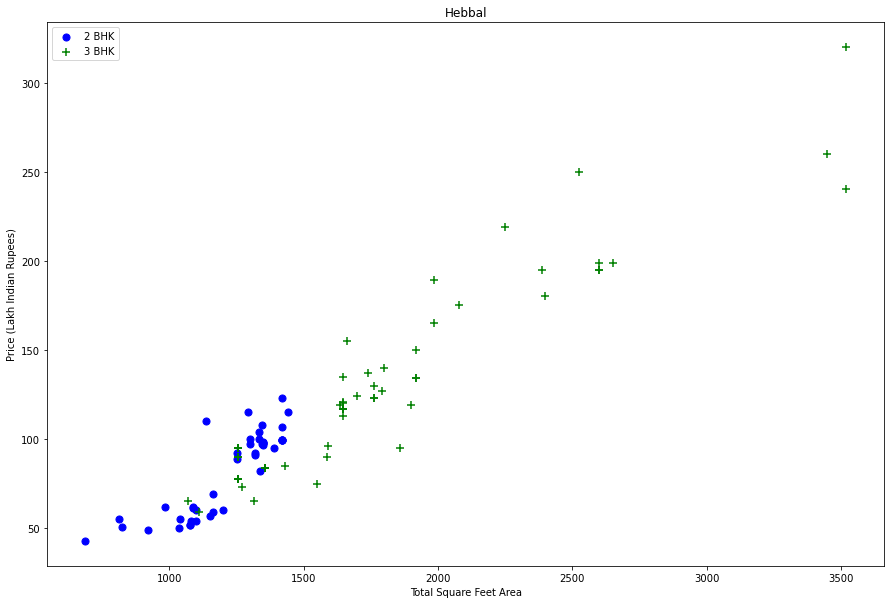

In [162]:

import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

**If n BHK price of a house is lesser than mean of n-1 BHK, we will remove it, provided: this will do for each location**


In [167]:
def remove_bhk_less(df):
    exclude_index =[]
    
    for location, location_df in df.groupby('location'):
        bhk_dic={}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_dic[bhk] = {
                            'mean':bhk_df.price_per_sqft.mean(),
                            'std': bhk_df.price_per_sqft.std(),
                            'count':bhk_df.shape[0]
                                }
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_prev = bhk_dic.get(bhk-1)
            if bhk_prev and bhk_prev['count']>5:
                exclude_index = np.append(exclude_index,bhk_df[bhk_df.price_per_sqft<(bhk_prev['mean'])].index.values)
    return df.drop(exclude_index,axis = 'index')
df8 = remove_bhk_less(df7)

**we have removed datas which has lesser price_per_sqft than mean price_per_sqft of previous BHK**

In [169]:
df8.shape

(7365, 7)

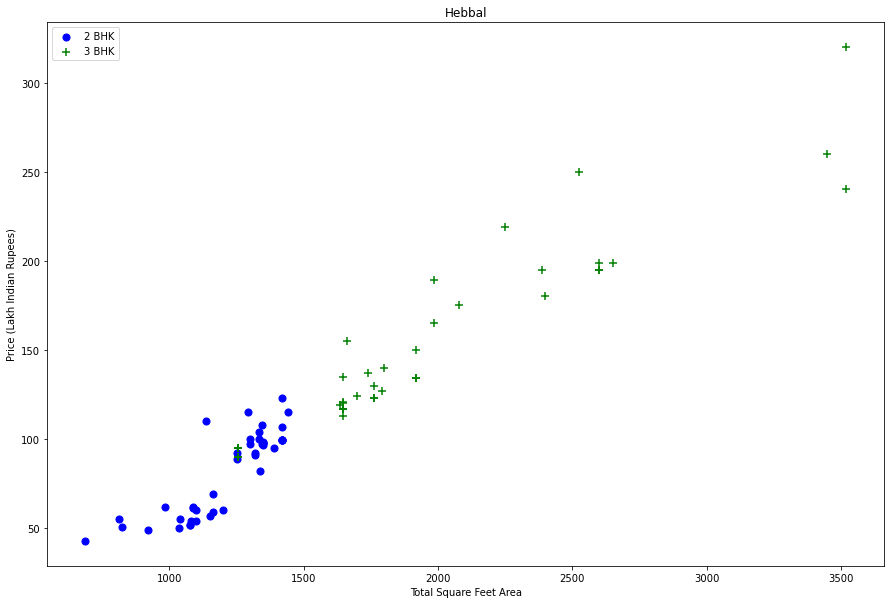

In [172]:
# After
plot_scatter_chart(df8,"Hebbal")

### See the hist of price per sqft

## Looks like normal distribution

Text(0, 0.5, 'Count')

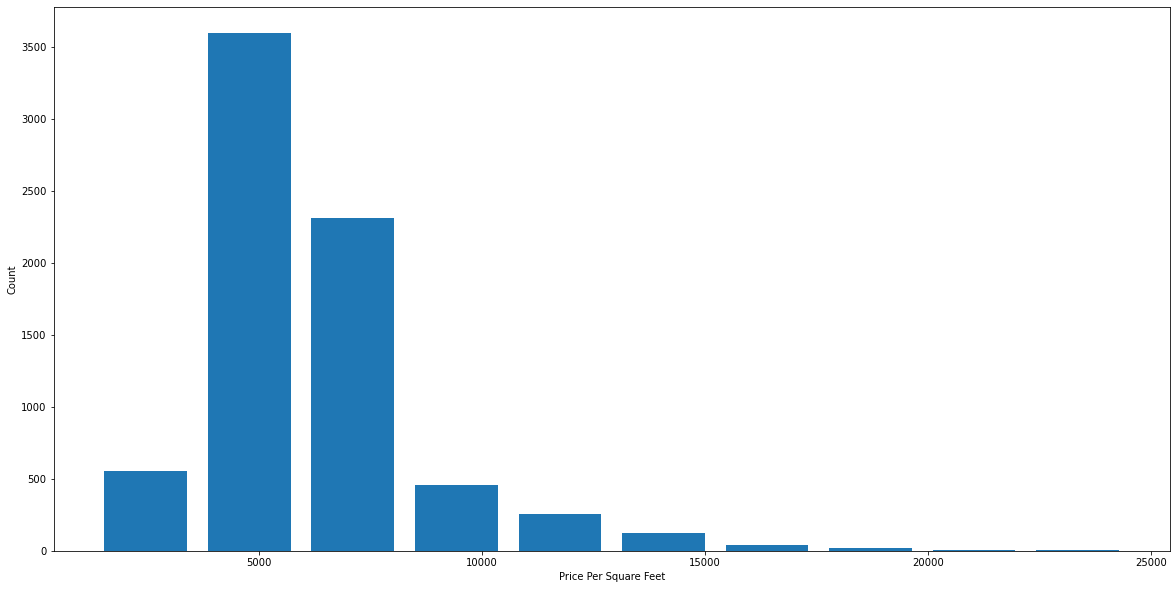

In [173]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")


<h2 style = "color : red"> Outlier Removal Using Bathrooms Feature</h2>

In [174]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

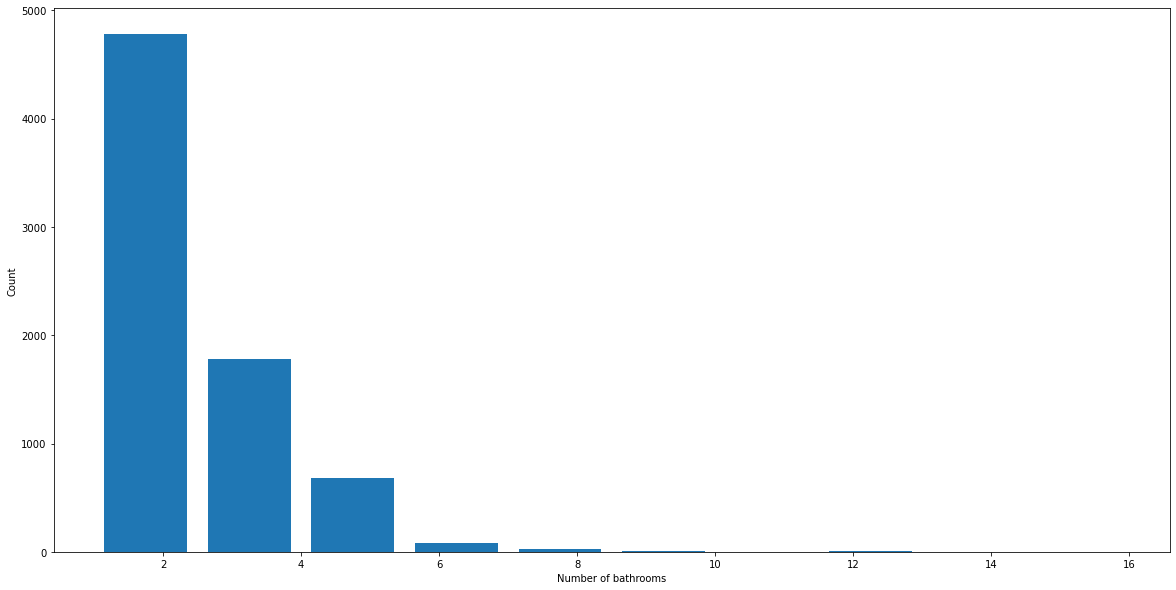

In [175]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [176]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5312,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8533,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8622,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9357,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9688,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [177]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5273,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6756,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8458,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [178]:

df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7286, 7)

In [179]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


**Now, we don't want size and price per sqft feature. price_per_sqft is created only for feature engineering. We have almost done with that**

In [181]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3



<h2 style = "color : red"> Use One Hot Encoding For Location</h2>

In [184]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1 style ="color:red"> Now Ready for model Buid</h1>

In [187]:
df12.shape

(7286, 244)

In [188]:
# independent varible
X = df12.drop('price',axis=1)

In [189]:
X.shape

(7286, 243)

In [190]:
y = df12.price

In [191]:
y.shape

(7286,)

## Train test split

In [192]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=10)

## Linear model

In [193]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

#accuracy
model.score(X_test,y_test)

0.8529894995402247

<h2 style ="color:red"> K-fold validation</h2>

In [194]:
from sklearn.model_selection import ShuffleSplit,cross_val_score

cv = ShuffleSplit(n_splits=5,random_state=0,test_size=.2)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.75697409, 0.85519688, 0.85024176, 0.88529063, 0.86350956])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style ="color:red">Find best model using GridSearchCV</h2>

In [196]:

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

/opt/anaconda3/envs/jenv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/envs/jenv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import ma

,model,best_score,best_params
0,linear_regression,0.842243,{'normalize': True}
1,lasso,0.693689,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.733203,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style ="color:red">Test the model for few properties</h2>

In [206]:
# this will give you location of the clolums
np.where(X.columns=='bhk')

(array([2]),)

In [200]:

def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]
    
    # make all other columns zero, since we have 242 features
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

In [201]:

predict_price('1st Phase JP Nagar',1000, 2, 2)

/opt/anaconda3/envs/jenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.69795778725882

<h2 style ="color:red">Export the tested model to a pickle file</h2>

In [207]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(model,f)

In [208]:
# f = open('bengluru','wb')
# pickle.dump(model,f)
# f.close()

<h2 style ="color:red">Export location and column information to a file that will be useful later on in our prediction application

</h2>

In [203]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))